## Import Packages and Functions

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import collections as col
import statistics
from scipy.interpolate import UnivariateSpline
import glob 
import math

## Load Data

In [30]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [31]:
modedatatype=([('file','i8'),('start','i8'),('end','i8'),('length','i8'),('mode','U1')])

In [32]:
mode_class = np.loadtxt(fname='mode_doc2.csv', delimiter=',', dtype=modedatatype)

In [33]:
file_names = glob.glob("../Parkes_archive_files/4500nsub/2019*.Fp.pdv")
file_names=sorted(file_names)

In [34]:
maxf=4032
minf=704

# FREQUENCY SCRUNCHED

## Create an Array of Pulses For Each Mode

In [35]:
mode_class = np.loadtxt(fname='mode_doc_3.csv', delimiter=',', dtype=modedatatype)

In [36]:
#Creating arrays for each mode, which contain the pulses for that mode
A=np.array([], dtype=fulldatatype)
B=np.array([], dtype=fulldatatype)
C=np.array([], dtype=fulldatatype)
D=np.array([], dtype=fulldatatype)
AVE=np.array([], dtype=fulldatatype)

A_len=np.array([])
B_len=np.array([])
C_len=np.array([])
D_len=np.array([])
U_len=np.array([])
N_len=np.array([])


for a in range(16):
    #Load in a file at a time
    print('File:', a)
    current_file = np.loadtxt(fname=file_names[a], dtype=fulldatatype)

    f = mode_class['file'] == a
    
    #Mode Arrays
    
    #Mode A
    #Isolate the pulses which are mode A and part of current file
    m = mode_class['mode'] == 'A'
    p = np.logical_and(f,m)
    mA = mode_class[p]
    
    #Find the number of mode A bursts
    num_A=np.sum(m)
    
    #For every burst
    for segment in mA:
        #Record the length of burst
        A_len = np.append(A_len,segment[3])
        #Then for every pulse in segment
        for b in range(segment[1],segment[2]+1):
            #Add all file lines for this pulse to an array
            s = current_file['pulse'] == b
            A = np.append(A,current_file[s])

    #Mode B
    m = mode_class['mode'] == 'B'
    p = np.logical_and(f,m)
    mB = mode_class[p]
    
    num_B=np.sum(m)
    
    for segment in mB:
        B_len = np.append(B_len,segment[3])
        for b in range(segment[1],segment[2]+1):
            s = current_file['pulse'] == b
            B = np.append(B,current_file[s])
            
    #Mode C
    m = mode_class['mode'] == 'C'
    p = np.logical_and(f,m)
    mC = mode_class[p]
    
    num_C=np.sum(m)
    
    for segment in mC:
        C_len = np.append(C_len,segment[3])
        for b in range(segment[1],segment[2]+1):
            s = current_file['pulse'] == b
            C = np.append(C,current_file[s])
            
    #Short Mode D
    m = mode_class['mode'] == 'D'
    p = np.logical_and(f,m)
    mD = mode_class[p]
    
    
    num_D=np.sum(m)
    
    for segment in mD:
        D_len = np.append(D_len,segment[3])
        for b in range(segment[1],segment[2]+1):
            s = current_file['pulse'] == b
            D = np.append(D,current_file[s])
            
    #Unknown
    m = mode_class['mode'] == 'U'
    p = np.logical_and(f,m)
    mU = mode_class[p]
    
    num_U=np.sum(m)
    
    for segment in mU:
        U_len = np.append(D_len,segment[3])
        
    #Null
    m = mode_class['mode'] == 'N'
    p = np.logical_and(f,m)
    mN = mode_class[p]
    
    num_N=np.sum(m)
    
    for segment in mN:
        N_len = np.append(N_len,segment[3])
            
    #Average
    m1 = mode_class['mode'] != 'N'
    m2 = mode_class['mode'] != 'O'
    m = np.logical_and(m1,m2)
    p = np.logical_and(f,m)
    mAVE = mode_class[p]
    
    num_AVE=np.sum(m)
    
    for segment in mAVE:
        for b in range(segment[1],segment[2]+1):
            s = current_file['pulse'] == b
            AVE = np.append(AVE,current_file[s])

File: 0
File: 1
File: 2
File: 3
File: 4
File: 5
File: 6
File: 7
File: 8
File: 9
File: 10
File: 11
File: 12
File: 13
File: 14
File: 15


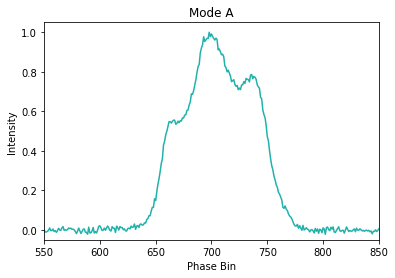

In [45]:
#Averaging the modes together
xA=np.array([])
yA=np.array([])

for c in range(1024):
    xA=np.append(xA,c)
    
    ph = A['phase'] == c
    it = A['intensity'][ph]
    
    yA=np.append(yA,sum(it)/len(it))
    
plt.plot(xA,yA/max(yA),color='lightseagreen')
plt.title('Mode A')
plt.xlabel('Phase Bin')
plt.ylabel('Intensity')
plt.axis([550,850,-0.05,1.05])
plt.savefig('png/A-Pos-C3')

In [46]:
expectedA=(0.5,660,6,2,695,20,1,740,8)
boundsA=([0,635,0,0,675,0,0,715,0],[np.inf,685,np.inf,np.inf,725,np.inf,np.inf,770,np.inf])


noise = sigmaClip(yA)
error = np.nanstd(noise[1])

#Fits gaussians to the data
params, cov, sigma = fitting_parameters(xA,yA,expectedA,boundsA)
fit = multi_gauss(xA,*params)

print('Mode A Profile Stats:')
print('Peak 1 Location:\t', params[4]*360/1080,sigma[4]*360/1080,'degrees')
print('Peak 2 Location:\t', params[7]*360/1080,sigma[7]*360/1080,'degrees')

W10,W50,W10e,W50e=find_widths(fit,params, cov)
print('W10:\t\t\t',W10,'bins \t')
print('\t\t\t', W10*(360/1024),'degrees')
print('W50:\t\t\t',W50,'bins \t')
print('\t\t\t', W50*(360/1024),'degrees')

Mode A Profile Stats:
Peak 1 Location:	 232.93496570074126 0.05006528553959594 degrees
Peak 2 Location:	 246.34780609824483 0.07649547675077012 degrees
W10:			 118.30965952167946 bins 	
			 41.59323967559044 degrees
W50:			 89.74862860440066 bins 	
			 31.552252243734607 degrees


Text(0, 0.5, 'Intensity')

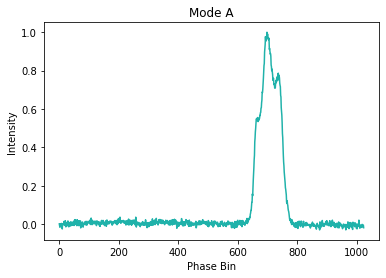

In [47]:

    
plt.plot(xA,yA/max(yA),color='lightseagreen')
plt.title('Mode A')
plt.xlabel('Phase Bin')
plt.ylabel('Intensity')
#plt.axis([0,1024,-0.03,0.04])
#plt.savefig('png/A-Pos-C3')

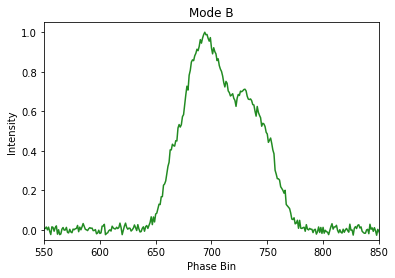

In [48]:
#Averaging the modes together
xB=np.array([])
yB=np.array([])

for c in range(1024):
    xB=np.append(xB,c)
    
    ph = B['phase'] == c
    it = B['intensity'][ph]
    
    yB=np.append(yB,sum(it)/len(it))
    
plt.plot(xB,yB/max(yB),color='forestgreen')
plt.title('Mode B')
plt.xlabel('Phase Bin')
plt.ylabel('Intensity')
plt.axis([550,850,-0.05,1.05])
plt.savefig('png/B-Pos-C3')

In [49]:
expectedB=(0.2,660,6,2,685,20,1,740,8)
boundsB=([0,635,0,0,675,0,0,715,0],[np.inf,685,np.inf,np.inf,725,np.inf,np.inf,770,np.inf])

noise = sigmaClip(yB)
error = np.nanstd(noise[1])

#Fits gaussians to the data
params, cov, sigma = fitting_parameters(xB,yB,expectedB,boundsB)
fit = multi_gauss(xB,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
profile_comp = gauss_peaks(fit, 1, 0, cov, params,minf,maxf,error,frequencies_rfi)

print('Mode B Profile Stats:')
print('Peak 1 Location:\t', params[4]*360/1080,sigma[4]*360/1080,'degrees')
print('Peak 2 Location:\t', params[7]*360/1080,sigma[7]*360/1080,'degrees')

W10,W50,W10e,W50e=find_widths(fit,params, cov)
print('W10:\t\t\t',W10,'bins \t')
print('\t\t\t', W10*(360/1024),'degrees')
print('W50:\t\t\t',W50,'bins \t')
print('\t\t\t', W50*(360/1024),'degrees')

Mode B Profile Stats:
Peak 1 Location:	 230.80151927829957 0.11831569660305162 degrees
Peak 2 Location:	 245.76730199124435 0.20852531766823054 degrees
W10:			 118.53454202916134 bins 	
			 41.67229993212703 degrees
W50:			 79.20195636245603 bins 	
			 27.84443778367595 degrees


[0, 300, -0.05, 0.05]

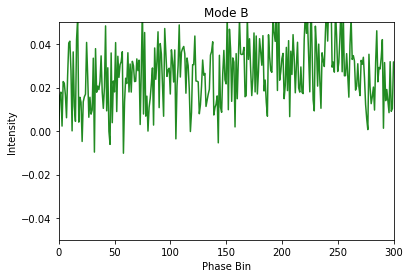

In [50]:
#Averaging the modes together
xB=np.array([])
yB=np.array([])

for c in range(1024):
    xB=np.append(xB,c)
    
    ph = B['phase'] == c
    it = B['intensity'][ph]
    
    yB=np.append(yB,sum(it)/len(it))
    
plt.plot(xB,yB/max(yB),color='forestgreen')
plt.title('Mode B')
plt.xlabel('Phase Bin')
plt.ylabel('Intensity')
plt.axis([0,300,-0.05,0.05])
#plt.savefig('png/B-Pos-C3')

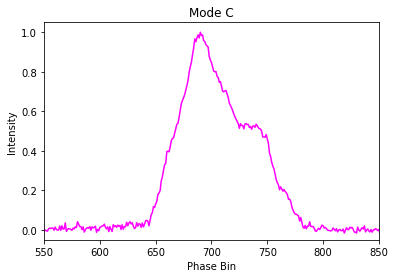

In [51]:
#Averaging the modes together
xC=np.array([])
yC=np.array([])

for c in range(1024):
    xC=np.append(xC,c)
    
    ph = C['phase'] == c
    it = C['intensity'][ph]
    
    yC=np.append(yC,sum(it)/len(it))
    
plt.plot(xC,yC/max(yC),color='magenta')
plt.title('Mode C')
plt.xlabel('Phase Bin')
plt.ylabel('Intensity')
plt.axis([550,850,-0.05,1.05])
plt.savefig('png/C-Pos-C3')

In [52]:
expectedC=(0.5,660,6,2,695,20,1,740,8)
boundsC=([0,635,0,0,675,0,0,715,0],[np.inf,685,np.inf,np.inf,725,np.inf,np.inf,770,np.inf])

noise = sigmaClip(yC)
error = np.nanstd(noise[1])

#Fits gaussians to the data
params, cov, sigma = fitting_parameters(xC,yC,expectedC,boundsC)
fit = multi_gauss(xC,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
profile_comp = gauss_peaks(fit, 1, 0, cov, params,minf,maxf,error,frequencies_rfi)

print('Mode C Profile Stats:')
print('Peak 1 Location:\t', params[4]*360/1080,sigma[4]*360/1080,'degrees')
print('Peak 2 Location:\t', params[7]*360/1080,sigma[7]*360/1080,'degrees')

W10,W50,W10e,W50e=find_widths(fit,params, cov)
print('W10:\t\t\t',W10,'bins \t')
print('\t\t\t', W10*(360/1024),'degrees')
print('W50:\t\t\t',W50,'bins \t')
print('\t\t\t', W50*(360/1024),'degrees')

Mode C Profile Stats:
Peak 1 Location:	 230.11520698853727 0.07080224261157764 degrees
Peak 2 Location:	 246.31548353443154 0.16534847053227436 degrees
W10:			 125.04971849210449 bins 	
			 43.962791657380485 degrees
W50:			 78.45727305714729 bins 	
			 27.582635059153343 degrees


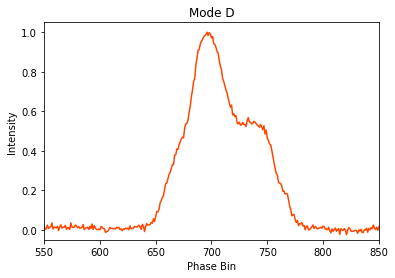

In [53]:
#Averaging the modes together
xD=np.array([])
yD=np.array([])

for c in range(1024):
    xD=np.append(xD,c)
    
    ph = D['phase'] == c
    it = D['intensity'][ph]
    
    yD=np.append(yD,sum(it)/len(it))
    
plt.plot(xD,yD/max(yD),color='orangered')
plt.title('Mode D')
plt.xlabel('Phase Bin')
plt.ylabel('Intensity')
plt.axis([550,850,-0.05,1.05])
plt.savefig('png/D-Pos-C3')

In [54]:
expectedD=(0.2,660,6,2,685,20,1,740,8)
boundsD=([0,635,0,0,675,0,0,715,0],[np.inf,685,np.inf,np.inf,725,np.inf,np.inf,770,np.inf])

noise = sigmaClip(yD)
error = np.nanstd(noise[1])

#Fits gaussians to the data
params, cov, sigma = fitting_parameters(xD,yD,expectedD,boundsD)
fit = multi_gauss(xD,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
profile_comp = gauss_peaks(fit, 1, 0, cov, params,minf,maxf,error,frequencies_rfi)

print('Mode D Profile Stats:')
print('Peak 1 Location:\t', params[4]*360/1080,sigma[4]*360/1080,'degrees')
print('Peak 2 Location:\t', params[7]*360/1080,sigma[7]*360/1080,'degrees')

W10,W50,W10e,W50e=find_widths(fit,params, cov)
print('W10:\t\t\t',W10,'bins \t')
print('\t\t\t', W10*(360/1024),'degrees')
print('W50:\t\t\t',W50,'bins \t')
print('\t\t\t', W50*(360/1024),'degrees')

Mode D Profile Stats:
Peak 1 Location:	 232.0842483374434 0.046238562452742736 degrees
Peak 2 Location:	 246.92071423274518 0.11830872201146793 degrees
W10:			 119.08059514248987 bins 	
			 41.86427172978159 degrees
W50:			 71.17441801640746 bins 	
			 25.022256333893246 degrees


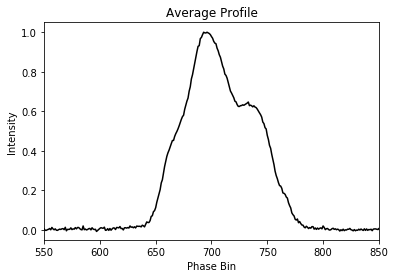

In [55]:
#Averaging the modes together
xAVE=np.array([])
yAVE=np.array([])

for c in range(1024):
    xAVE=np.append(xAVE,c)
    
    ph = AVE['phase'] == c
    it = AVE['intensity'][ph]
    
    yAVE=np.append(yAVE,sum(it)/len(it))
    
plt.plot(xAVE,yAVE/max(yAVE),color='black')
plt.title('Average Profile')
plt.xlabel('Phase Bin')
plt.ylabel('Intensity')
plt.axis([550,850,-0.05,1.05])
plt.savefig('png/Ave-Pos-C3')

In [56]:
expectedAVE=(0.15,660,6,0.55,695,20,0.1,715,10,0.25,740,8)
boundsAVE=([0,625,0,0,675,0,0,712,0,0,720,0],[np.inf,675,np.inf,np.inf,725,np.inf,np.inf,740,np.inf,np.inf,760,np.inf])

noise = sigmaClip(yAVE)
error = np.nanstd(noise[1])

#Fits gaussians to the data
params, cov, sigma = fitting_parameters(xAVE,yAVE,expectedAVE,boundsAVE)
fit = multi_gauss(xAVE,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
profile_comp = gauss_peaks(fit, 1, 0, cov, params,minf,maxf,error,frequencies_rfi)

print('Average Profile Stats:')
print('Peak 1 Location:\t', profile_comp[1][0],'degrees')
print('Peak 2 Location:\t', profile_comp[2][0],'degrees')

W10,W50,W10e,W50e=find_widths(fit,params, cov)
print('W10:\t\t\t',W10,'bins \t')
print('\t\t\t', W10*(360/1024),'degrees')
print('W50:\t\t\t',W50,'bins \t')
print('\t\t\t', W50*(360/1024),'degrees')

Average Profile Stats:
Peak 1 Location:	 243.741351182411 degrees
Peak 2 Location:	 258.94762889447543 degrees
W10:			 121.96929156347483 bins 	
			 42.87982906528412 degrees
W50:			 79.36591853120183 bins 	
			 27.902080733625642 degrees


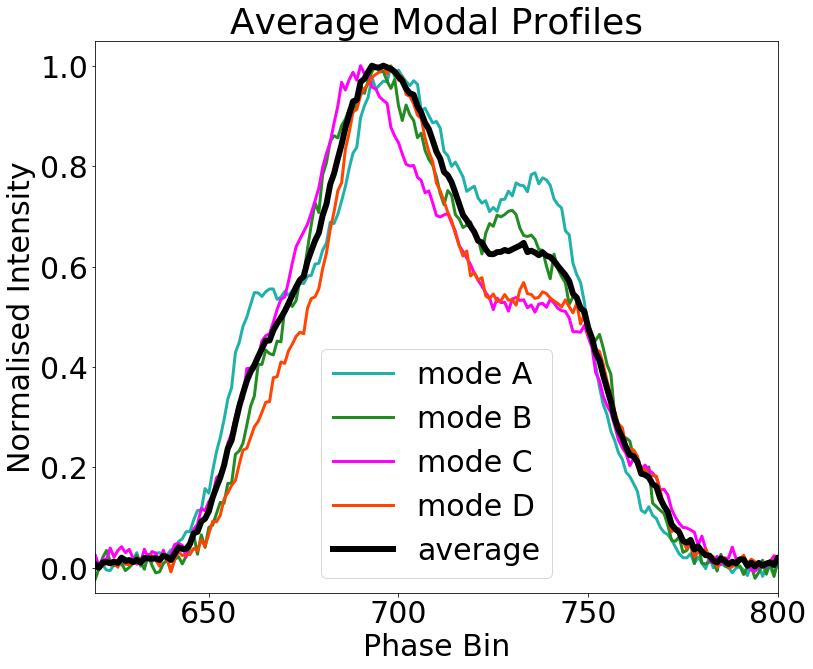

In [69]:
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(12, 10))
plt.plot(xA,yA/max(yA),label='mode A', color='lightseagreen',lw=3)
plt.plot(xA,yB/max(yB),label='mode B', color='forestgreen',lw=3)
plt.plot(xA,yC/max(yC),label='mode C', color='magenta',lw=3)
plt.plot(xA,yD/max(yD),label='mode D', color='orangered',lw=3)
plt.plot(xAVE,yAVE/max(yAVE),label='average', color='black',lw=6)
plt.title('Average Modal Profiles')
plt.xlabel('Phase Bin')
plt.ylabel('Normalised Intensity')
plt.legend()
plt.axis([620,800,-0.05,1.05])
plt.tight_layout()
plt.savefig('png/Profiles-poster')

In [58]:
A_len=[31,56,86,69,53]

Mode A Stats:
Number of Bursts: 5
Length Min, Ave and Max: 31 59.0 86
Percentage 7.682291666666667


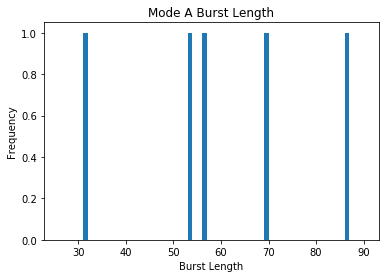

In [59]:
plt.hist(A_len, range(int(min(A_len))-5,5+int(max(A_len))));
plt.title('Mode A Burst Length')
plt.xlabel('Burst Length')
plt.ylabel('Frequency')
print('Mode A Stats:')
print('Number of Bursts:', len(A_len))
print('Length Min, Ave and Max:', min(A_len),np.average(A_len), max(A_len))
print('Percentage',(sum(A_len)/3840)*100)

Mode B Stats:
Number of Bursts: 7
Length Min, Ave and Max: 13.0 22.0 28.0
Percentage 4.010416666666667


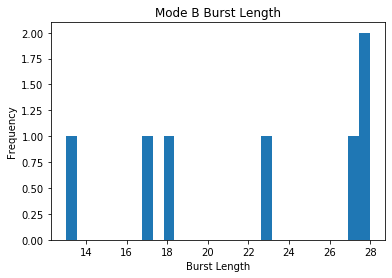

In [60]:
plt.hist(B_len, int(max(B_len)));
plt.title('Mode B Burst Length')
plt.xlabel('Burst Length')
plt.ylabel('Frequency')
print('Mode B Stats:')
print('Number of Bursts:', num_B)
print('Length Min, Ave and Max:', min(B_len),np.average(B_len), max(B_len))
print('Percentage',(sum(B_len)/3840)*100)

In [ ]:
C_len

In [ ]:
C_len[31]=6
C_len=np.delete(C_len,30)

In [ ]:
len(C_len)

In [ ]:
plt.hist(C_len, int(max(C_len)),color='magenta');
plt.title('Mode C Burst Length')
plt.xlabel('Burst Length')
plt.ylabel('Frequency')
print('Mode C Stats:')
print('Number of Bursts:', len(C_len))
print('Length Min, Ave and Max:', min(C_len),np.average(C_len), max(C_len))
print('Percentage',(sum(C_len)/3840)*100)
plt.tight_layout()
plt.savefig('png/modeChist')

In [ ]:
D_len

In [ ]:
D_len[7]=31
D_len=np.delete(D_len,6)

In [ ]:
D_len

In [ ]:
D_len[8]=64
D_len=np.delete(D_len,7)

In [ ]:
D_len

In [ ]:
D_len[12]=50
D_len=np.delete(D_len,11)

In [ ]:
plt.hist(D_len, int(max(D_len)));
plt.title('Mode D Burst Length')
plt.xlabel('Burst Length')
plt.ylabel('Frequency')
print('Mode D Stats:')
print('Number of Bursts:', len(D_len))
print('Length Min, Ave and Max:', min(D_len),np.average(D_len), max(D_len))
print('Percentage',(sum(D_len)/3840)*100)

In [ ]:
print('Mode U Stats:')
print('Number of Bursts:', len(U_len))
print('Length Min, Ave and Max:', min(U_len),np.average(U_len), max(U_len))
print('Percentage',(sum(U_len)/3840)*100)

In [ ]:
print('Mode N Stats:')
print('Number of Bursts:', len(N_len))
print('Length Min, Ave and Max:', min(N_len),np.average(N_len), max(N_len))
print('Percentage',(sum(N_len)/3840)*100)

#  P3 Analysis

In [ ]:
print(A_len,B_len,C_len,D_len)

In [ ]:
A_p3=[14,14,16.8,13.8,13.25]
A_p3_err=[1,1.87,1.75,1.44,1.77]
B_p3=[7,7,6,6,5.75,7,6.75]
B_p3_err=[1,1,1.13,1,0.77,0.93,0.90]
D_p3=[6,11.88,11,7.58,15.5,5.6,8,9.5,10]
D_p3_err=[1,0.67,2.29,0.64,2.59,0.59,1,3.17,1.05]

In [ ]:
plt.figure(figsize=(10,4))
plt.hist([A_len, B_len, C_len, D_len], bins=list(range(0,88)),rwidth=0.9,color=['lightseagreen','forestgreen', 'magenta','orangered'],label=['Mode A','Mode B','Mode C', 'Mode D'],stacked=True)
plt.legend()
plt.xlabel('Burst Length (P1)')
plt.ylabel('Frequency of Occurence')
plt.title('Burst Length Distribution')
plt.tight_layout()
plt.savefig('png/lendist')

In [ ]:
#plt.hist(A_p3, int(max(A_p3)),color='lightseagreen',stacked=True)
#plt.hist(B_p3, int(max(B_p3)),color='forestgreen',stacked=True)
#plt.hist(D_p3, int(max(D_p3)),color='orangered',stacked=True)

plt.hist([A_p3, B_p3, D_p3], bins=list(range(4,19)),rwidth=0.9,color=['lightseagreen','forestgreen','orangered'],label=['Mode A','Mode B', 'Mode D'],stacked=True)
plt.legend()
plt.xlabel('P3 (P1)')
plt.ylabel('Frequency of Occurence')
plt.title('Burst P3 Distribution')
plt.tight_layout()
plt.savefig('png/p3dist')

In [ ]:
D_len2=[18,107,55,91,31,28,26,19,50]

plt.errorbar(A_len,A_p3,yerr=A_p3_err,fmt='o',color='lightseagreen',label='Mode A')
plt.errorbar(B_len,B_p3,yerr=B_p3_err,fmt='o',color='forestgreen',label='Mode B')
plt.errorbar(D_len2,D_p3,yerr=D_p3_err,fmt='o',color='orangered', label='Mode D')

plt.title('Burst Length vs P3')
plt.xlabel('Burst Length')
plt.ylabel('P3')
plt.legend()
plt.tight_layout()
plt.savefig('png/p3vlength')

In [ ]:
plt.hist(A_p3, int(max(A_p3)))

In [ ]:
plt.hist(B_p3, int(max(B_p3)))

In [ ]:
plt.hist(D_p3, int(max(D_p3)))

In [ ]:
Ave_a=[14.37]
Ave_b=[6.50]
len_a=[59]
len_b=[22]
Ave_d=[9.45]
len_d=[42.92]
er_d=[0.57]
plt.plot(len_a,Ave_a,'o',color='lightseagreen',label='Mode A')
plt.plot(len_b,Ave_b,'o',color='forestgreen',label='Mode B')
#plt.plot(len_d,Ave_d,'o',color='orangered',label='Mode D')
plt.errorbar(len_d,Ave_d,yerr=er_d,fmt='o',color='orangered', label='Mode D')

p3=[14.37,6.5,9.45]
leng=[59,22,42.92]
err=[1,1,0.57]

def linear(x, m, c):
    return ((m * np.array(x)) + c)

y_range=list(range(0,60))
#Fit a linear 
paramslin,covlin=curve_fit(linear,leng,p3,sigma=err, maxfev=10000)
fit_errorlin=np.sqrt(np.diag(covlin))
fitlin = linear(y_range, *paramslin)

print(paramslin,fit_errorlin)

plt.plot(y_range,fitlin,color='lightgrey')

plt.title('Burst Length vs P3')
plt.xlabel('Burst Length')
plt.ylabel('P3')
plt.legend()
plt.tight_layout()
plt.savefig('png/AVEp3vlength')

# RFI Frequencies

In [42]:
maxf=4032
minf=704
frange=maxf-minf
#scrunch=max(average['frequency'])+1
scrunch=26
wband=int((frange/scrunch)//1)
frequency_list=list(range(0,26))

In [43]:
rfi_channels=[0,1,2,3,4,5,6,7,8,9,10,11,12,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,211,212,213,214,215,216,217,218,219,220,221,222,223,239,240,241,242,243,244,250,251,252,253,254,255,256,257,258,259,260,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,914,915,916,917,918,919,920,921,922,1024,1025,1026,1027,1028,1029,1030,1031,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1272,1273,1274,1275,1276,1277,1278,1279,1280,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1618,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983]

In [44]:
frequencies_rfi=frequency_calc(minf,maxf,frequency_list,rfi_channels)

70         49         63
192         58         191
318         13         319
454         37         447
576         28         575
703         0         703
831         0         831
962         9         959
1079         40         1087
1216         17         1215
1343         3         1343
1478         18         1471
1576         46         1599
1734         13         1727
1855         0         1855
1984         18         1983
2111         0         2111
2239         0         2239
2367         0         2367
2495         0         2495
2623         0         2623
2751         0         2751
2879         0         2879
3007         0         3007
3135         0         3135
3263         0         3263


# ACROSS FREQUENCY

## FUNCTIONS

In [ ]:
component = col.namedtuple('component','phase intensity')
ind_component = col.namedtuple('component','phase intensity width')
pulse_component = col.namedtuple('pulse_component','frequency comp1 comp2 errors')
component_separation = col.namedtuple('component_separation','frequency separation')

In [ ]:
def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))\

def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

In [ ]:
"""
    Used to get the parameters, covariance matrix and errors for any number of gaussian fits, through and expected value. 
"""
def fitting_parameters(x,y,expected,bound):
    """
    bound=([],[])
    for i in range(len(expected)):
        bound[0].append(0)
        bound[1].append(np.inf)
    """
        
    params,cov=curve_fit(multi_gauss,x,y,expected, bounds=bound)
    sigma=np.sqrt(np.diag(cov))
    return params, cov, sigma

In [ ]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.
    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

In [ ]:
def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x

    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [ ]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = sqrt.J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian

    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err

In [ ]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all peaks of a gaussian function, where the derivative is equal to zero. 

    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)            
            
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)
    
    return minima, maxima, minima_e, maxima_e

In [ ]:
def gauss_peaks(fit, nofreqband, freqband, pcov, params, freq_low, freq_high, noise, frequencies_rfi, data = 'parkes', freq=0):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    pcov: list
        the covariance matrix from the fit
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    
    deg_mod=360/len(fit)
    
    ##Find the peaks of the fit, and the intensity at those peaks
    #minima, peakpos, minima_e, err = find_minima_maxima_gauss(params, pcov, len(fit))
    #peakint = multi_gauss(peakpos, *params)
    
    err=[]
    err2=[]
    peakpos=[]
    peakint=[]
    
    uncert=np.sqrt(np.diag(pcov))
    
    for h in range(1,len(params),3):
        peakpos=np.append(peakpos,params[h])
        err=np.append(err,uncert[h])
        peakint=np.append(peakint,params[h-1])
        err2=np.append(err2,uncert[h-1])
    
    if len(peakpos)==4:
        peakpos=np.delete(peakpos,2)
        peakint=np.delete(peakint,2)
        err=np.delete(err,2)  
        err2=np.delete(err2,2)
    if len(peakpos)==3:
        peakpos=np.delete(peakpos,0)
        peakint=np.delete(peakint,0)
        err=np.delete(err,0)
        err2=np.delete(err2,0)
        
    #Removes peaks until only two highest remain - which also have to be the lasttwo peaks
    #If the highest do not correspond to the last, the frequency band is not used
    while len(peakpos)>2:
        mn=min(peakint)
        peakint = list(peakint)
        rm = peakint.index(mn)
        if rm!=len(peakpos)-1:
            del peakpos[rm]
            del peakint[rm]
            del err[rm]
            del err2[rm]
        else:
            break 

    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    
    component1=0
    component2=0
    errr=[]
    errr2=[]
    
    if(max(peakint)/noise)>3:
        if data=='parkes':
            for n,p in enumerate(peakpos):
                if p>670 and p<710:
                    component1 = component(phase=(deg_mod)*peakpos[n], intensity=peakint[n])
                    errr.append(err[n])
                    errr2.append(err2[n])
                elif p>720:
                    component2 = component(phase=(deg_mod)*peakpos[n], intensity=peakint[n])
                    errr.append(err[n])
                    errr2.append(err2[n])
        elif data!='parkes' and len(peakpos)==2:
            component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
            errr.append(err[0])
            errr2.append(err2[0])
            component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
            errr.append(err[1])
            errr2.append(err2[1])
    else:
        print("Too noisey", freqband)
                
    if component1==0 or component2==0:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0   
        print("peaks",len(peakpos),peakpos,"band", freqband)
    else:
        error = [np.array(errr)*(deg_mod),errr2]

    #Converts the frequency from bins to MHz    
    if data=='parkes':
        #freq=(((freq_high-freq_low)/nofreqband)*(freqband))+freq_low+((freq_high-freq_low)/(nofreqband*2))
        freq=frequencies_rfi[freqband]
    else:
        freq=freq[freqband]

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

In [ ]:
def fit_peaks(fit, freqband, pcov, params, noise, frequency):
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    peakpos = params[1]
    paramint = params[0]
    errcov = np.sqrt(np.diag(pcov))
    err = errcov[1]
    err2 = errcov[0]
    if len(params)>3:
        peakpos=np.append(peakpos,params[4])
        paramint=np.append(paramint,params[3])
        err = np.append(err,errcov[4])
        err2 = np.append(err2,errcov[3])
    if len(params)>6:
        peakpos=np.append(peakpos,params[7])
        paramint=np.append(paramint,params[6])
        err=np.append(err,errcov[7])
        err2 = np.append(err2,errcov[6])

    print(peakpos)
    peakint = multi_gauss(peakpos, *params)
    print(peakint)

    #Removes peaks until only two highest remain - which also have to be the two outer peaks
    #If the highest do not correspond to the outer, the frequency band is not used
    while len(peakpos)>2:
        mn=min(paramint)
        paramint = list(paramint)
        rm = paramint.index(mn)   
        print(rm)
        peakpos=np.delete(peakpos,rm)
        peakint=np.delete(peakint,rm)
        err=np.delete(err,rm)
        err2=np.delete(err2,rm)

    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    
    component1=0
    component2=0
    errr=[]
    errr2=[]
    
    if(max(peakint)/noise)>3:
        if len(peakpos)==2:
            component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
            errr.append(err[0])
            errr2.append(err2[0])
            component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
            errr.append(err[1])
            errr2.append(err2[1])
    else:
        print("Too noisey", freqband)
                
    if component1==0 or component2==0:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0   
        print("peaks",len(peakpos),peakpos,"band", freqband)
    else:
        error = [np.array(errr)*(deg_mod),np.array(errr2)]

    #Converts the frequency from bins to MHz    
    freq=frequency[freqband]
    
    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

In [ ]:
"""
    Graphing Sub-pulse operation:
    Used to get the correct x, y and error arrays created for graphing the data and finding a fit.
"""
def graphing_comp(fit_comp,comp_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        for i in range(0,len(fit_comp)):
            if fit_comp[i][comp_num][0]!=0:
                phase_comp.append(fit_comp[i][comp_num][0])
                frequency_comp.append(fit_comp[i][0])
                comp_err.append(fit_comp[i][3][0][comp_num-1])

        return phase_comp, frequency_comp, comp_err    

In [ ]:
"""
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors (greater than 100 degrees).
"""
def detect_outlier(frequency_comp, phase_comp, comp_err , threshold):
    phase=[]
    frequency=[]
    err=[]
    
    #Find mean and standard deviation of data
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    for i in range(len(phase_comp)):
        #Find z score
        z_score= (phase_comp[i] - mean_1)/std_1 
        #Only include points which have a z score under the threshold value, and with errors less than 100 degrees
        if np.abs(z_score) < threshold and comp_err[i]<5:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

In [ ]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))
def linear(x, m, c):
    return ((m * np.array(x)) + c)

In [ ]:
"""
    Used to gain separation of components values and the uncertainties. 
"""
def separation_singleprofile(components_array):
    sep_array=[]
    uncert=[]

    #Go through all the different frequencies
    for i in range(0,len(components_array)):
        if components_array[i][1][0] != 0 and components_array[i][2][0] != 0:
            freq=components_array[i][0]
            #Subtract second component from first
            sep=(components_array[i][2][0]) - (components_array[i][1][0])
            single_sep=component_separation(frequency=freq, separation=sep)
            sep_array.append(single_sep)
            #Calculate uncertainty
            uncert.append(np.sqrt((components_array[i][3][0][0])**2 + (components_array[i][3][0][1])**2))
    return sep_array, uncert

In [ ]:
def plot_peaks(x,y,profile_comp):
    plt.plot(x,y, lw=1)
    plt.plot(x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    plt.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    plt.xlabel('Phase (deg)')
    plt.ylabel('Intensity')
    plt.legend()
    return

In [ ]:
def component_positions(averageprofiles,expected1,bounds1,minf,maxf,frequencies_rfi):
    fit_components = []
    no_freq_bands=max(averageprofiles['frequency'])+1

    #Loop thought all of the frequency bands
    for freqband in range(0,no_freq_bands):
        f = averageprofiles['frequency'] == freqband
        x=averageprofiles['phase'][f]
        y=averageprofiles['intensity'][f]

        noise = sigmaClip(y)
        error = np.nanstd(noise[1])

        #Fit the gaussians and find peaks and errors, create array with all frequencies
        #Resulting frequencies are in MHz and phase in degrees
        if len(x)!=0 and len(y)!=0:
            try:
                params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
                fit = multi_gauss(x,*params)
                profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params, minf,maxf,error,frequencies_rfi)
            except:
                component1 = component(phase=0, intensity=0)
                component2 = component(phase=0, intensity=0)
                error = 0             
                #freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
                freq=frequencies_rfi[freqband]
                profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
            fit_components.append(profile_comp)
    return fit_components

In [ ]:
def plot_comp_movement(fit_components,title,colour,comnum,outlierrem):
    #Separate the array into x and y axis of phase and frequency which can be graphed
    phase_comp1, frequency_comp1, comp1_err=graphing_comp(fit_components,comnum)
    #Plot points
    #plt.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color='red')
    plt.title(title)
    plt.xlabel('Phase (deg)')
    plt.ylabel('Frequency')
    #Remove outliers which are greater than 'threshold' number of std away from the mean
    frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err,outlierrem)
    #Plot outlier removed points"
    plt.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color=colour,label='data')
    
    #Fit the thorsett model to the component position
    y_range=list(range(minf,maxf))
    #Fit a linear 
    comp1_paramslin,comp1_covlin=curve_fit(linear,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
    comp1_fit_errorlin=np.sqrt(np.diag(comp1_covlin))
    comp1_fitlin = linear(y_range, *comp1_paramslin)
    
    print('Params',comp1_paramslin,comp1_fit_errorlin)
    #Plot linear
    #plt.plot(comp1_fitlin, y_range,color='black',lw=2, label='linear fit', zorder=1)
    #plt.legend()

    return comp1_fitlin, y_range

In [ ]:
def plot_sep_movement(fit_components,title,colour,outlierrem):
    y_range=list(range(minf,maxf))
    #Gain component separation values
    component_sep, sep_error = separation_singleprofile(fit_components)
    comp_sep=[]
    frequency_forsep=[]
    #Put them into arrays for graphing
    for i in range(0,len(component_sep)):
        comp_sep.append(component_sep[i][1])
        frequency_forsep.append(component_sep[i][0])
    
    #Plot points
    #plt.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color='red', fmt='.', lw=0.5)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('\u0394\u03B8 (deg)')
    #Remove outliers
    frequency_forsep, comp_sep, sep_error = detect_outlier(frequency_forsep, comp_sep, sep_error, outlierrem)
    #Plot points with outliers removed
    plt.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color=colour, fmt='.', lw=0.5, label='data')
    print(len(frequency_forsep))
    plt.title(title)
    
    #Create a thorsett fit
    expect=(100,0.5,5)
    sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
    sep_fit_error=np.sqrt(np.diag(sep_cov))
    separation_fit=thorsett(y_range,*sep_params)
    print(len(frequency_forsep))
    
    plt.plot(y_range,separation_fit, color='lightgrey',lw=1,label='empirical fit',zorder=0.1)
    return y_range, separation_fit, sep_params, frequency_forsep,comp_sep,sep_error

In [ ]:
def find_widths(profile, popt, pcov):
    #perform spline operations on the fit
    x = np.linspace(0, len(profile)-1, len(profile))
    fit = multi_gauss(x, *popt)
    amp_fit = max(fit) - min(fit)
    spline10 = UnivariateSpline(x, fit - np.full(len(x), 0.1*amp_fit), s=0)
    spline50 = UnivariateSpline(x, fit - np.full(len(x), 0.5*amp_fit), s=0)

    #find W10, W50 and Wscat
    W10_roots = spline10.roots()
    W50_roots = spline50.roots()
    W10 = W10_roots[-1] - W10_roots[0]
    W50 = W50_roots[-1] - W50_roots[0]

    #W10 root errors
    err_10 = find_x_err(W10_roots, popt, pcov)
    W10_e = np.sqrt(err_10[0]**2 + err_10[-1]**2)

    #W50 root errors
    err_50 = find_x_err(W50_roots, popt, pcov)
    W50_e = np.sqrt(err_50[0]**2 + err_50[-1]**2)
    
    return W10, W50, W10_e, W50_e

In [ ]:
def plot_intensities(fit_components, title, colour):  
    #Find intensity of component1
    intensity_comp1=[]
    frequency_comp1=[]
    intensity_comp2=[]
    frequency_comp2=[]
    err1=[]
    err2=[]

    for i in range(0,len(fit_components)):
        if fit_components[i][1][0] != 0:
            intensity_comp1.append(fit_components[i][1][1])
            frequency_comp1.append(fit_components[i][0])
            err1.append(fit_components[i][3][1][0])
            intensity_comp2.append(fit_components[i][2][1])
            frequency_comp2.append(fit_components[i][0])
            err2.append(fit_components[i][3][1][1])

    int_ratio=np.array(intensity_comp1)/np.array(intensity_comp2)
    int_err=[]
    for h in list(range(0,len(int_ratio))):
        i_err=int_ratio[h]*np.sqrt((err1[h]/intensity_comp1[h])**2+(err2[h]/intensity_comp2[h])**2)
        int_err.append(i_err)

    plt.errorbar(frequency_comp2,int_ratio, yerr=int_err, fmt='.', lw=0.5, color=colour,label='data')
    plt.title('Intensity Ratio of Component 1/Component 2')
    plt.xlabel('Frequency')
    plt.ylabel('Intensity Ratio')
    plt.title(title)
    
    #Fit the thorsett model to the component position
    y_range=list(range(minf,maxf))
    #Fit a linear 
    ratio_paramslin,ratio_covlin=curve_fit(linear,frequency_comp2,int_ratio, maxfev=10000) #sigma=comp1_err)
    ratio_fit_errorlin=np.sqrt(np.diag(ratio_covlin))
    ratio_fitlin = linear(y_range, *ratio_paramslin)
    
    #Plot linear
    plt.plot(y_range,ratio_fitlin,color='lightgrey',lw=1, label='linear fit', zorder=1)
    plt.legend()
    
    return y_range, ratio_fitlin, ratio_paramslin

In [ ]:
def frequency_calc(minf,maxf,frequency_list,rfi_channels):
    frange=maxf-minf
    scrunch=max(frequency_list)+1
    wband=int((frange/scrunch)//1)
    
    true_freq=[]

    for chan in frequency_list:

        w=0
        num_chan=0
        sums=np.array([])

        while w<wband:

            try: b=rfi_channels.index(int((wband*chan)+w))
            except ValueError:
                sums=np.append(sums,int((wband*chan)+w))

            w=w+1

        centre_bin=int(np.average(sums)//1)
        print(centre_bin,'       ',128-len(sums),'       ',int(wband*chan+(wband/2))-1)

        centre_frequ=(centre_bin)+minf

        true_freq.append(centre_frequ)
    return true_freq

In [ ]:
def plot_comp_both_movement(fit_components,title,colour,outlierrem):
    #Separate the array into x and y axis of phase and frequency which can be graphed
    phase_comp1, frequency_comp1, comp1_err=graphing_comp(fit_components,1)

    #Remove outliers which are greater than 'threshold' number of std away from the mean
    frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err,outlierrem)
  
    #Fit the thorsett model to the component position
    y_range=list(range(minf,maxf))
    #Fit a linear 
    comp1_paramslin,comp1_covlin=curve_fit(linear,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
    comp1_fit_errorlin=np.sqrt(np.diag(comp1_covlin))
    comp1_fitlin = linear(y_range, *comp1_paramslin)
    
    #Separate the array into x and y axis of phase and frequency which can be graphed
    phase_comp2, frequency_comp2, comp2_err=graphing_comp(fit_components,2)

    #Remove outliers which are greater than 'threshold' number of std away from the mean
    frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err,outlierrem)
  
    #Fit a linear 
    comp2_paramslin,comp2_covlin=curve_fit(linear,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
    comp2_fit_errorlin=np.sqrt(np.diag(comp2_covlin))
    comp2_fitlin = linear(y_range, *comp2_paramslin)
    
    
    #Plot linear
    #plt.plot(comp1_fitlin, y_range,color='black',lw=2, label='linear fit', zorder=1)
    #plt.legend()

    plt.figure(figsize=(8,4))
    plt.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, color=colour, fmt='.', lw=0.5, zorder=1)
    plt.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, color=colour, fmt='.', lw=0.5,label='Data', zorder=1)
    plt.plot(comp1_fitlin,y_range, color='lightgrey', label='Linear Fit', zorder=0)
    plt.plot(comp2_fitlin,y_range, color='lightgrey', zorder=0)
    plt.title(title)
    plt.xlabel('Phase (deg)')
    plt.ylabel('Frequency (MHz)')
    #plt.legend()
    
    return 

In [ ]:
def plot_comp_resid(fit_components,title,colour,outlierrem):
    #Separate the array into x and y axis of phase and frequency which can be graphed
    phase_comp1, frequency_comp1, comp1_err=graphing_comp(fit_components,1)

    #Remove outliers which are greater than 'threshold' number of std away from the mean
    frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err,outlierrem)
  
    #Fit the thorsett model to the component position
    y_range=list(range(minf,maxf))
    #Fit a linear 
    comp1_paramslin,comp1_covlin=curve_fit(linear,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
    comp1_fit_errorlin=np.sqrt(np.diag(comp1_covlin))
    comp1_fitlin = linear(y_range, *comp1_paramslin)
    
    #Separate the array into x and y axis of phase and frequency which can be graphed
    phase_comp2, frequency_comp2, comp2_err=graphing_comp(fit_components,2)

    #Remove outliers which are greater than 'threshold' number of std away from the mean
    frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err,outlierrem)
  
    #Fit a linear 
    comp2_paramslin,comp2_covlin=curve_fit(linear,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
    comp2_fit_errorlin=np.sqrt(np.diag(comp2_covlin))
    comp2_fitlin = linear(y_range, *comp2_paramslin)
    
    comp1_fitlin3 = linear(frequency_comp1, *comp1_paramslin)
    comp2_fitlin3 = linear(frequency_comp2, *comp2_paramslin)
    
    comp1_resid_lin = phase_comp1 - comp1_fitlin3
    comp2_resid_lin = phase_comp2 - comp2_fitlin3
    
    
    fig = plt.figure(figsize=(12, 5))
    grid = plt.GridSpec(1, 6, hspace=0, wspace=0)
    resid_1 = fig.add_subplot(grid[0, 0])
    plt.ylabel('Frequency (MHz)')
    main_ax = fig.add_subplot(grid[0, 1:5], sharey=resid_1)
    plt.xlabel('Phase (deg)')
    resid_2 = fig.add_subplot(grid[0, 5], sharey=resid_1)

    resid_1.plot(comp1_resid_lin, frequency_comp1, '.', color='darkgoldenrod')
    main_ax.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, color='darkgoldenrod', fmt='.', lw=0.5, label='Component 1', zorder=1)
    main_ax.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, color='blue', fmt='.', lw=0.5, label='Component 2', zorder=1)
    main_ax.plot(comp1_fitlin,y_range, color='darkgrey',lw=2, zorder=0)
    main_ax.plot(comp2_fitlin,y_range, color='darkgrey',lw=2, zorder=0)
    resid_2.plot(comp2_resid_lin, frequency_comp2, '.', color='b')

    resid_1.set_title('C1 Residuals')
    resid_2.set_title('C2 Residuals')
    main_ax.set_title('Average Profile - Component Phase Positions')

    main_ax.legend(loc='upper center')
    resid_1.label_outer()
    main_ax.label_outer()
    resid_2.label_outer()
    
    return 